In [1]:
# ==========================================
# 1. Imports & Setup
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoModel
from tqdm.notebook import tqdm
import os
import wandb
import tinycudann as tcnn

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cuda


In [19]:
# ==========================================
# 2. Helper Functions
# ==========================================
def load_image(path, size=256):
    """이미지를 불러와 흑백 변환 및 정규화"""
    try:
        img = Image.open(path).convert('L')
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
        
    img = img.resize((size, size))
    img_tensor = torch.from_numpy(np.array(img)).float() / 255.0
    return img_tensor.unsqueeze(0).unsqueeze(0).to(device) # [1, 1, H, W]

def get_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

# ==========================================
# 3. Models
# ==========================================
class SimpleINR(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=4):
        super().__init__()
        layers = []
        # Input: (x, y) coords -> Output: (gray)
        layers.append(nn.Linear(2, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid()) 
        self.net = nn.Sequential(*layers)

    def forward(self, H, W):
        ys = torch.linspace(-1, 1, H, device=device)
        xs = torch.linspace(-1, 1, W, device=device)
        yy, xx = torch.meshgrid(ys, xs, indexing='ij')
        coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2)
        out = self.net(coords)
        return out.reshape(1, 1, H, W)

class FourierINR(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=4, mapping_size=256, scale=10.0):
        super().__init__()
        self.mapping_size = mapping_size
        self.scale = scale
        
        self.register_buffer('B', torch.randn((2, mapping_size)) * scale)
        
        layers = []
        # Input: (sin, cos) features * mapping_size -> Output: (gray)
        # 입력 차원이 2 -> 2 * mapping_size로 뻥튀기됨
        layers.append(nn.Linear(2 * mapping_size, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, H, W):
        ys = torch.linspace(-1, 1, H, device=self.B.device)
        xs = torch.linspace(-1, 1, W, device=self.B.device)
        yy, xx = torch.meshgrid(ys, xs, indexing='ij')
        coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2) # [HW, 2]
        
        # [Fourier Feature Mapping]
        # x -> [sin(2pi * B @ x), cos(2pi * B @ x)]
        x_proj = (2.0 * np.pi * coords) @ self.B # [HW, mapping_size]
        emb = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1) # [HW, 2*mapping_size]
        
        out = self.net(emb)
        return out.reshape(1, 1, H, W)

class TCNN_INR(nn.Module):
    def __init__(self, device):
        super().__init__()
        encoding_config = {
            "otype": "Grid",
            "type": "Hash",
            "n_levels": 12,
            "n_features_per_level": 4,
            "log2_hashmap_size": 20,
            "base_resolution": 16,
            "per_level_scale": 1.5,
            "interpolation": "Linear"
        }
        network_config = {
            "otype": "FullyFusedMLP",
            "activation": "ReLU",
            "output_activation": "None",
            # "output_activation": "Sigmoid",
            "n_neurons": 128,
            "n_hidden_layers": 2,
        }

        self.model = tcnn.NetworkWithInputEncoding(
            n_input_dims=2,
            n_output_dims=1,
            encoding_config=encoding_config,
            network_config=network_config,
        ).to(device)

    def forward(self, H, W):
        # TCNN expects inputs in [0, 1] range
        ys = torch.linspace(0, 1, H, device=device)
        xs = torch.linspace(0, 1, W, device=device)
        yy, xx = torch.meshgrid(ys, xs, indexing='ij')
        coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2) # [HW, 2]
        
        out = self.model(coords)
        return out.reshape(1, 1, H, W)

# (2) MASt3R-Style Matching Head
class MatchingHead(nn.Module):
    def __init__(self, input_dim=384, output_dim=24, patch_size=16):
        super().__init__()
        self.patch_size = patch_size
        # MLP: DINO feat -> (24 * 16 * 16) expansion
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.GELU(),
            nn.Linear(512, output_dim * (patch_size ** 2))
        )

    def forward(self, x, H, W):
        # x: DINO Patch Features [B, N, 384]
        B, N, C = x.shape
        x = self.mlp(x) # [B, N, 24*256]
        
        # Reshape to grid
        H_grid, W_grid = H // self.patch_size, W // self.patch_size
        x = x.transpose(1, 2).reshape(B, -1, H_grid, W_grid)
        
        # Pixel Shuffle [B, 24, H, W]
        x = F.pixel_shuffle(x, self.patch_size)
        
        # Cosine Similarity를 위해 Normalize 수행
        return F.normalize(x, dim=1) 

# Augmentation Manager (Fixed vs Infinite)
class AugmentationManager:
    def __init__(self, infinite=False, num_fixed=10, max_shift=15.0, H=256, W=256, device='cuda'):
        self.infinite = infinite
        self.max_shift = max_shift
        self.H = H; self.W = W
        self.device = device
        
        # 고정된 Augmentation 미리 생성
        self.fixed_shifts = []
        if not infinite:
            print(f"[Aug] Generating {num_fixed} fixed augmentations...")
            for _ in range(num_fixed):
                sx = np.random.uniform(-max_shift, max_shift)
                sy = np.random.uniform(-max_shift, max_shift)
                self.fixed_shifts.append((sx, sy))
    
    def get_shift(self):
        if self.infinite:
            # 매번 새로운 랜덤 시프트
            sx = np.random.uniform(-self.max_shift, self.max_shift)
            sy = np.random.uniform(-self.max_shift, self.max_shift)
            return sx, sy
        else:
            # 고정된 리스트에서 랜덤 선택
            idx = np.random.randint(0, len(self.fixed_shifts))
            return self.fixed_shifts[idx]

In [20]:
# ==========================================
# 4. Joint Trainer
# ==========================================
class JointTrainer:
    def __init__(self, device, config):
        self.device = device
        self.cfg = config
        self.use_corr = config.get("use_correspondence", True)
        
        # WandB Init
        if self.cfg.get("wandb", True):
            wandb.init(project="Single-Image-Optimization", config=config)

        # 1. Models
        print("Loading Models...")
        self.inr = SimpleINR().to(device)
        
        if self.use_corr:
            self.dino = AutoModel.from_pretrained('facebook/dinov3-vits16-pretrain-lvd1689m').to(device).eval()
            for p in self.dino.parameters(): p.requires_grad = False
            self.head = MatchingHead().to(device)
            
            # Optimizer for Head + INR
            self.optimizer = torch.optim.Adam([
                {'params': self.inr.parameters(), 'lr': config["lr_inr"]},
                {'params': self.head.parameters(), 'lr': config["lr_head"]}
            ])
        else:
            # Optimizer for INR only
            self.optimizer = torch.optim.Adam([
                {'params': self.inr.parameters(), 'lr': config["lr_inr"]}
            ])

        # Utils
        self.mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
        self.ce_loss = nn.CrossEntropyLoss()
        
        # State
        self.augmentor = AugmentationManager(
            infinite=config["infinite_augmentation"],
            num_fixed=10,
            max_shift=config["max_shift"],
            device=device
        )
        self.latest_viz_data = {}

    def extract_desc(self, img):
        if not self.use_corr: return None
        B, C, H, W = img.shape
        img_3ch = img.repeat(1, 3, 1, 1)
        img_norm = (img_3ch - self.mean) / self.std
        
        H_grid = H // 16; W_grid = W // 16
        num_patches = H_grid * W_grid
        
        with torch.no_grad():
            out = self.dino(pixel_values=img_norm, output_hidden_states=True)
            patch_feats = out.last_hidden_state[:, -num_patches:, :]
        
        return self.head(patch_feats, H, W)

    def train_step(self, clean_img, step):
        self.optimizer.zero_grad()
        B, C, H, W = clean_img.shape
        
        # --- A. Augmentation ---
        shift_x, shift_y = self.augmentor.get_shift()
        
        tx = -shift_x / (W / 2.0)
        ty = -shift_y / (H / 2.0)
        
        theta = torch.tensor([[1, 0, tx], [0, 1, ty]], dtype=torch.float, device=self.device).unsqueeze(0)
        grid = F.affine_grid(theta, clean_img.size(), align_corners=False)
        target_img = F.grid_sample(clean_img, grid, align_corners=False) # Shifted GT
        
        # --- B. Rendering ---
        pred_img = self.inr(H, W)
        
        logs = {}
        total_loss = 0.0
        
        if self.use_corr:
            # --- C. InfoNCE & Alignment ---
            desc_pred = self.extract_desc(pred_img)
            desc_target = self.extract_desc(target_img)
            
            # (1) InfoNCE Loss
            num_samples = 4096
            flat_inds = torch.randperm(H * W, device=self.device)[:num_samples]
            ys = flat_inds // W
            xs = flat_inds % W
            
            feats_q = desc_pred[0, :, ys, xs].T
            
            ys_tgt = torch.clamp(ys + int(round(shift_y)), 0, H-1)
            xs_tgt = torch.clamp(xs + int(round(shift_x)), 0, W-1)
            feats_k_pos = desc_target[0, :, ys_tgt, xs_tgt].T
            
            logits = torch.matmul(feats_q, feats_k_pos.T) / 0.1 
            labels = torch.arange(num_samples, device=self.device)
            loss_nce = self.ce_loss(logits, labels)
            
            # (2) Alignment Loss (Nearest Neighbor)
            with torch.no_grad():
                flat_target = desc_target.view(24, -1)
            
            # Global Search for Pred Samples
            sim = torch.matmul(feats_q.detach(), flat_target)
            match_idx = sim.argmax(dim=1)
            
            pred_pixels = pred_img.view(1, -1)[:, flat_inds].T
            target_pixels = target_img.view(1, -1)[:, match_idx].T
            loss_align = F.mse_loss(pred_pixels, target_pixels)

            naive_loss = F.mse_loss(pred_img, target_img)
            w_align = self.cfg["w_align"]
            w_naive = self.cfg["w_naive"]
            
            total_loss = loss_nce + (loss_align * w_align) + (naive_loss * w_naive) 
            
            logs["Loss/InfoNCE"] = loss_nce.item()
            logs["Loss/Align_INR"] = loss_align.item()
            logs["Loss/Naive_MSE"] = naive_loss.item()
            
            # --- Calc Correspondence Error for Viz ---
            # Head가 찾은 match_idx가 실제 GT(ys_tgt, xs_tgt)와 얼마나 다른가?
            match_ys = match_idx // W
            match_xs = match_idx % W
            
            err_y = (match_ys - ys_tgt).float().abs().mean()
            err_x = (match_xs - xs_tgt).float().abs().mean()
            corr_err = (err_y + err_x) / 2.0
            logs["Metrics/Corr_Error_Px"] = corr_err.item()
            
        else:
            # --- Naive Baseline (Just L1 against Shifted Target) ---
            loss_naive = F.mse_loss(pred_img, target_img)
            total_loss = loss_naive
            logs["Loss/Naive_MSE"] = loss_naive.item()

        # --- D. Update & Logs ---
        total_loss.backward()
        
        # Log Gradients & LR
        logs["Train/GradNorm_INR"] = get_grad_norm(self.inr)
        logs["Train/LR_INR"] = self.optimizer.param_groups[0]['lr']
        if self.use_corr:
            logs["Train/GradNorm_Head"] = get_grad_norm(self.head)
        
        self.optimizer.step()
        logs["Loss/Total"] = total_loss.item()
        
        # Save for visualization
        if step % 500 == 0:
            self.latest_viz_data = {
                    "pred": pred_img.detach(),
                    "target": target_img.detach(),
                    "clean": clean_img.detach(),
                    "gt_shift": (shift_x, shift_y),
                    "step": step
                }
        
        if self.cfg.get("wandb", True) and step % 10 == 0:
            wandb.log(logs, step=step)
            
        return logs

    def compute_dense_error_map(self, pred, target, gt_shift):
        """시각화를 위해 전체 픽셀에 대한 에러 맵을 계산 (Batch 처리)"""
        B, C, H, W = pred.shape
        desc_pred = self.extract_desc(pred)   # [1, 24, H, W]
        desc_target = self.extract_desc(target) # [1, 24, H, W]
        
        flat_pred = desc_pred.view(24, -1).T  # [HW, 24]
        flat_target = desc_target.view(24, -1).T # [HW, 24]
        
        shift_x, shift_y = gt_shift
        error_map_x = torch.zeros(H, W)
        error_map_y = torch.zeros(H, W)
        
        # 메모리 절약을 위해 Chunk 단위로 계산
        chunk_size = 4096 
        num_pixels = H * W
        
        for i in range(0, num_pixels, chunk_size):
            end = min(i + chunk_size, num_pixels)
            
            # 1. Query Chunk
            q_chunk = flat_pred[i:end] # [Chunk, 24]
            
            # 2. Global Search
            # [Chunk, HW] -> Argmax
            sim = torch.matmul(q_chunk, flat_target.T)
            match_idx = sim.argmax(dim=1).cpu()
            
            # 3. Predicted Coords
            pred_y_idx = match_idx // W
            pred_x_idx = match_idx % W
            
            # 4. GT Expected Coords
            # i ~ end 사이의 픽셀 좌표
            indices = torch.arange(i, end)
            ys = indices // W
            xs = indices % W
            
            gt_y_idx = torch.clamp(ys + int(round(shift_y)), 0, H-1)
            gt_x_idx = torch.clamp(xs + int(round(shift_x)), 0, W-1)
            
            # 5. Calculate Error (Predicted - GT)
            diff_y = pred_y_idx - gt_y_idx
            diff_x = pred_x_idx - gt_x_idx
            
            error_map_y.view(-1)[i:end] = diff_y.float()
            error_map_x.view(-1)[i:end] = diff_x.float()
            
        return error_map_x, error_map_y
        
    def visualize(self):
        if not self.latest_viz_data: return
        data = self.latest_viz_data
        
        pred = data["pred"]
        targ = data["target"]
        clean = data["clean"]
        step = data["step"]
        gt_shift = data["gt_shift"]
        
        # 1. Image Residual
        res = (pred - clean).abs()
        
        # 2. Compute Correspondence Error Map (Only if use_corr is True)
        if self.use_corr:
            err_x, err_y = self.compute_dense_error_map(pred, targ, gt_shift)
        else:
            # Correspondence를 안 쓰면 에러 맵을 계산할 수 없으므로 0으로 채움
            H, W = pred.shape[-2:]
            err_x = torch.zeros(H, W)
            err_y = torch.zeros(H, W)
        
        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Row 1: Images
        axes[0,0].imshow(clean[0].permute(1,2,0).squeeze().cpu(), cmap='gray', vmin=0, vmax=1)
        axes[0,0].set_title("GT Canonical (Unmoved)")
        
        axes[0,1].imshow(targ[0].permute(1,2,0).squeeze().cpu(), cmap='gray', vmin=0, vmax=1)
        axes[0,1].set_title(f"Target (Shift: {gt_shift[0]:.1f}, {gt_shift[1]:.1f})")
        
        axes[0,2].imshow(pred[0].permute(1,2,0).squeeze().cpu(), cmap='gray', vmin=0, vmax=1)
        axes[0,2].set_title(f"Learned Canonical (Step {step})")
        
        # Row 2: Errors
        # Residual
        im_res = axes[1,0].imshow(res[0].permute(1,2,0).squeeze().cpu(), cmap='inferno', vmin=0, vmax=0.1)
        axes[1,0].set_title("Recon Error (vs GT Canonical)")
        plt.colorbar(im_res, ax=axes[1,0])
        
        # Error X Map
        im_ex = axes[1,1].imshow(err_x, cmap='RdBu', vmin=-10, vmax=10)
        title_x = "Corr Error X (px)" if self.use_corr else "Corr Error X (N/A)"
        axes[1,1].set_title(title_x)
        plt.colorbar(im_ex, ax=axes[1,1])
        
        # Error Y Map
        im_ey = axes[1,2].imshow(err_y, cmap='RdBu', vmin=-10, vmax=10)
        title_y = "Corr Error Y (px)" if self.use_corr else "Corr Error Y (N/A)"
        axes[1,2].set_title(title_y)
        plt.colorbar(im_ey, ax=axes[1,2])
        
        plt.tight_layout()
        
        if self.cfg.get("wandb", True):
             wandb.log({
                "Visual/Result": wandb.Image(fig),
             }, step=step)
        
        plt.show()
        plt.close(fig)

In [21]:
# Configuration
config = {
    "wandb": True,
    "epochs": 50001,
    "use_correspondence": True, 
    # "use_correspondence": False, # just naive MSE
    "lr_inr": 1e-3,
    "lr_head": 1e-4,
    
    # Augmentation Config
    "infinite_augmentation": False, # False: 고정된 10개만 사용
    "max_shift": 10.0,
    
    # Loss Weight Mixing
    "w_align": 1.0,  # Correspondence L1 (Main)
    # "w_naive": 0.1,  # Naive L1 (Stabilizer)
    "w_naive": 0.0,
}

# Load Data
clean_image = load_image("/home/minsukc/SIO/data/ct_chest_2_resized_256x256.png")

# Train
trainer = JointTrainer(device, config)

Loss/Align_INR,██▆▆▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/InfoNCE,█▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/Naive_MSE,██▆▄▅▅▄▅▃▁▃▇▅▃▅▅▂▂▅▅▁▂▇▂▂▂▅▂▅▅▅▅▂▆▂▇▇▁▁▁
Loss/Total,█▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Metrics/Corr_Error_Px,█▆▅▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train/GradNorm_Head,▆▅▂█▆▅▂▄▂▄▁▁▂▂▁▂▁▂▁▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Train/GradNorm_INR,█▄▁▆▂▄▆▂▂▃▃▃▃▂▂▂▂▁▂▁▂▂▁▁▁▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂
Train/LR_INR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/Align_INR,0.00361
Loss/InfoNCE,1.11849
Loss/Naive_MSE,0.05563


Loading Models...
[Aug] Generating 10 fixed augmentations...


Start Training (Correspondence: True)...


  0%|          | 0/50001 [00:00<?, ?it/s]

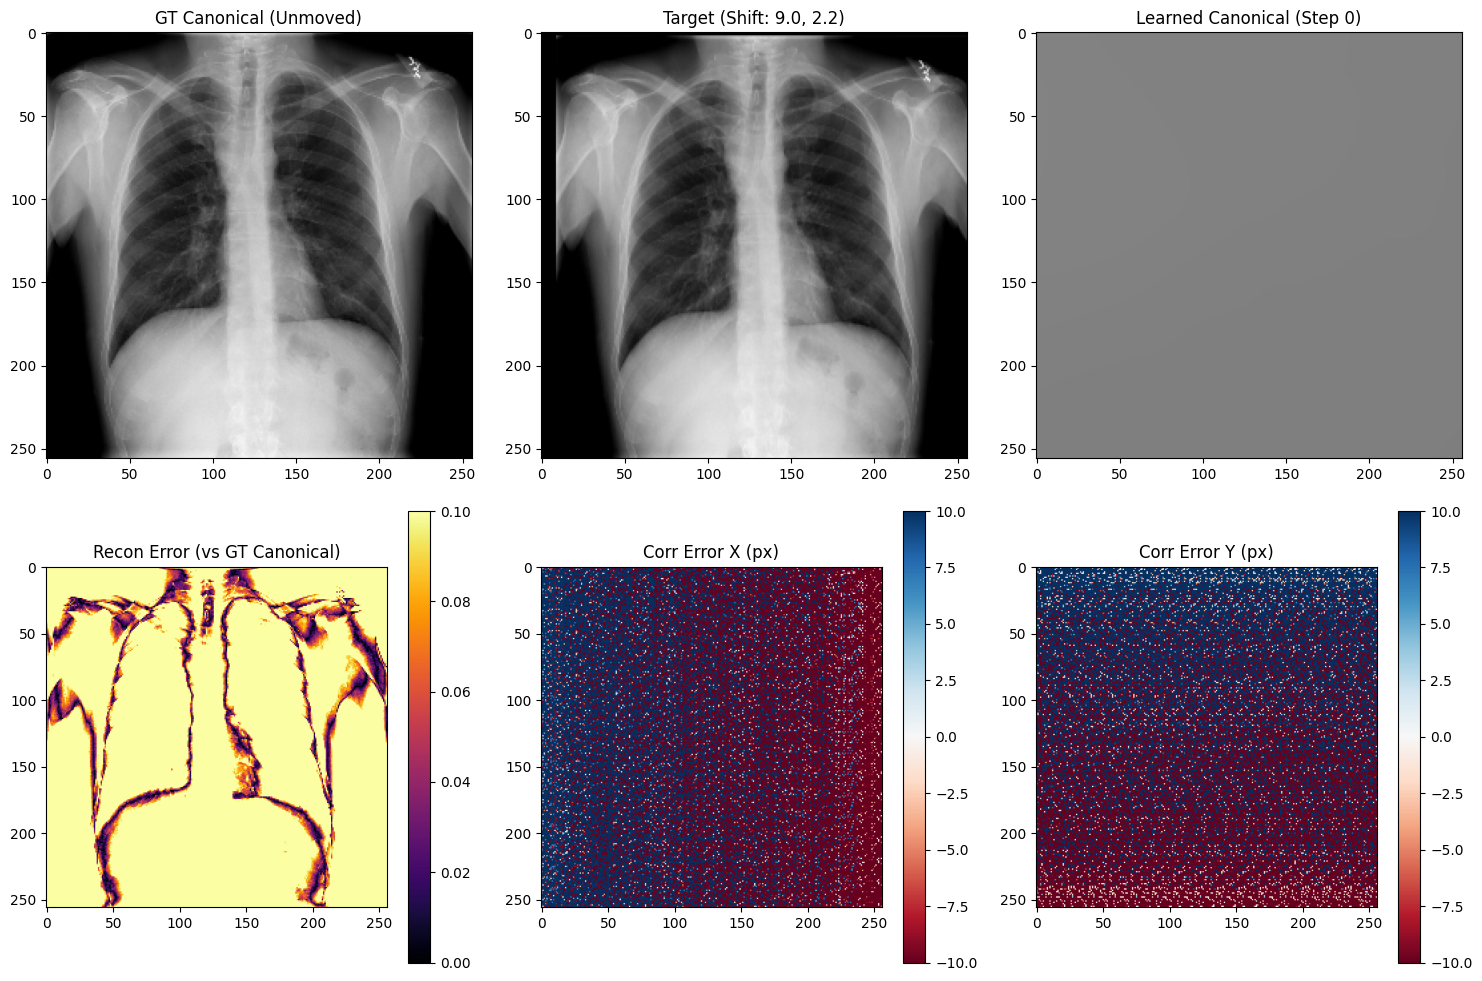

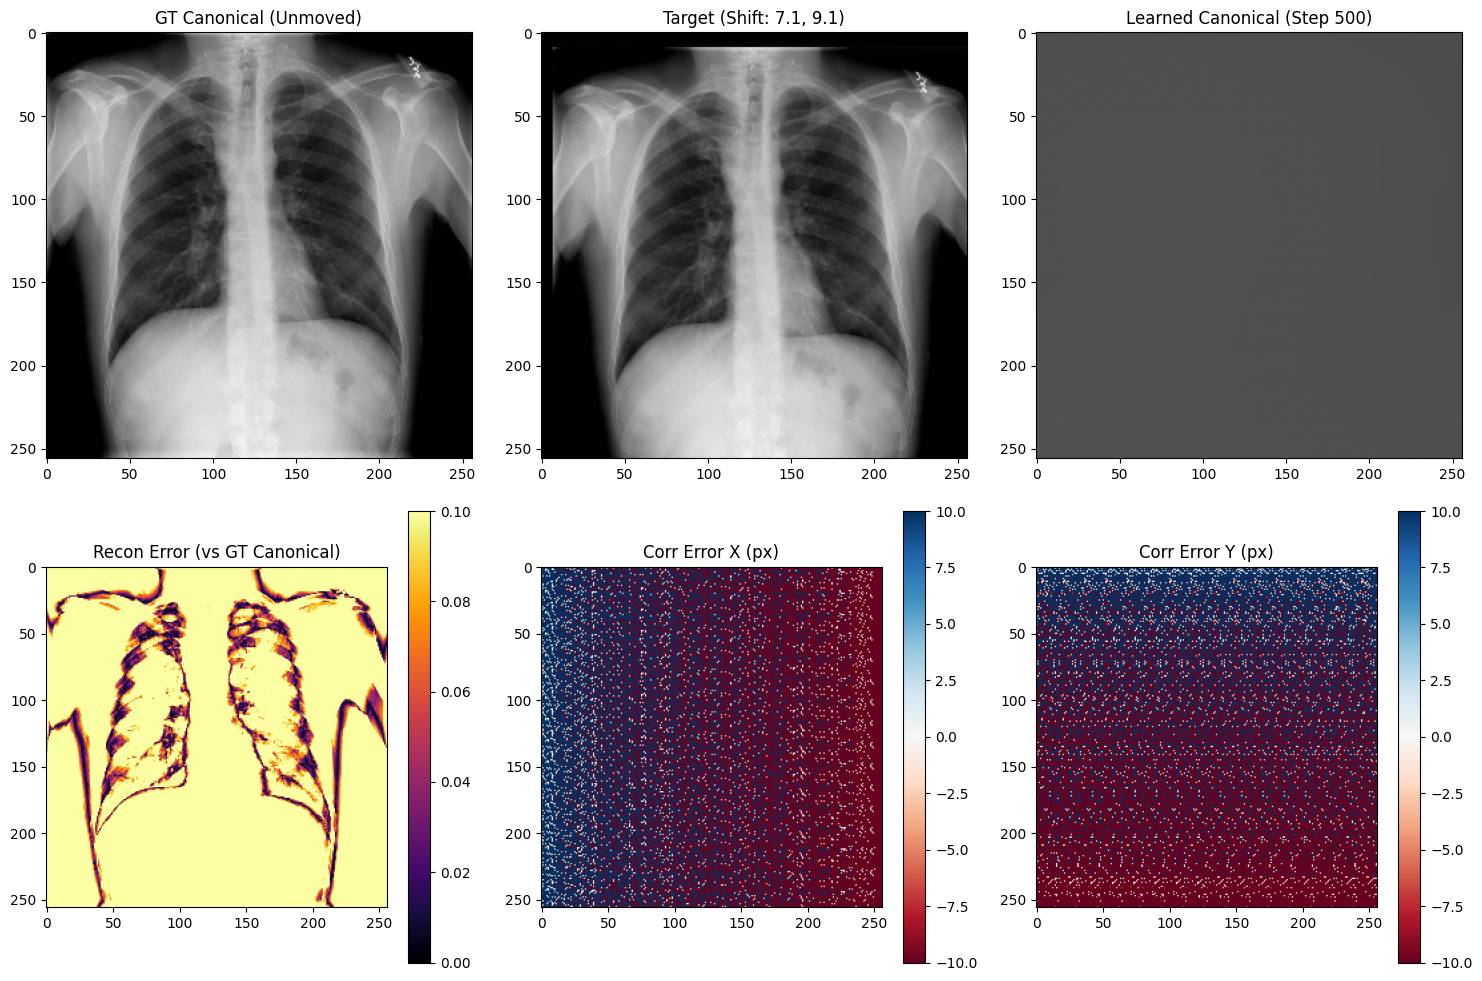

In [ ]:
print(f"Start Training (Correspondence: {config['use_correspondence']})...")

pbar = tqdm(range(config["epochs"]))
for step in pbar:
    logs = trainer.train_step(clean_image, step)
    
    if step % 10 == 0:
        desc = f"Loss: {logs['Loss/Total']:.4f}"
        if config["use_correspondence"]:
            desc += f" | Err: {logs['Metrics/Corr_Error_Px']:.2f}px"
        pbar.set_postfix_str(desc)
        
    if step % 500 == 0:
        trainer.visualize()

print("Done.")
if config["wandb"]: wandb.finish()